

** V2** uses the following formulae from
https://www.myclimate.org/en/information/about-myclimate/downloads/flight-emission-calculator/
(accessed 27/06/2024 11:18)


The non-CO2e best estimate is recommended to be 2xCO2 so total multiplier is 3. This is from Nitrous Oxides, Contrails and cirrus clouds. The former have a **massive** uncertainty of +/-100% 90%CL due to being a flegling field and very difficult to calculate.

UK gov recommendation: https://assets.publishing.service.gov.uk/media/5d19c4fc40f0b609cfd97461/non-CO2-effects-report.pdf

x=distance+DC

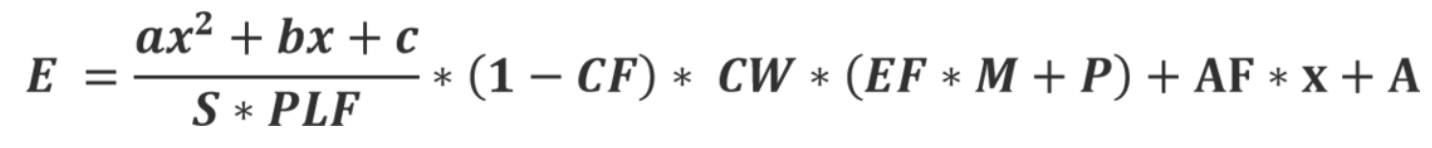

In [1]:
import pandas as pd
import airportsdata
import matplotlib
import matplotlib.pyplot as plt
import json
from mpl_toolkits.basemap import Basemap
import matplotlib.colors as colors
import numpy as np
import geopy.distance as dist
import io
import pandas as pd

#calculation from
#https://www.myclimate.org/en/information/about-myclimate/downloads/flight-emission-calculator/

long_cut=2500
interpolate_above=1500
short_haul_factors=pd.read_csv(io.StringIO('''
S,157.86
PLF,0.796
DC,95
CF,0.26
E_CW,1
P_CW,1
B_CW,1.5
F_CW,1.5
EF,3.16
P,0.538
M,3
AF,0.00034
A,11.68
a,0.000007
b,2.775
c,1260.608

'''), header=None)
keys=list(short_haul_factors[0])
vals=list(short_haul_factors[1])
short_haul_factors={k:vals[i] for i,k in enumerate(keys)}
long_haul_factors=pd.read_csv(io.StringIO('''
S,302.58
PLF,0.82
DC,95
CF,0.26
E_CW,1
P_CW,1.5
B_CW,4
F_CW,5
EF,3.16
P,0.538
M,3
AF,0.00034
A,11.68
a,0.00029
b,3.475
c, 3259.691

'''), header=None)
keys=list(long_haul_factors[0])
vals=list(long_haul_factors[1])
long_haul_factors={k:vals[i] for i,k in enumerate(keys)}
def calculate_emission_for_factors(factors,distance):
    #caculate kg of CO2
    x=factors['DC']+distance
    E=(factors['a']*x**2+factors['b']*x+factors['c'])/(factors['S']*factors['PLF'])
    E*=(1-factors['CF'])*factors['E_CW']*(factors['EF']*factors['M']+factors['P'])
    E+=factors['AF']*x+factors['A']
    return E
def calc_emissions_v2(distance):
    #not yet calculating layovers
    if distance>=long_cut:
        return 2*(calculate_emission_for_factors(long_haul_factors,distance))/1e3
    elif distance<=interpolate_above:
        return 2*(calculate_emission_for_factors(short_haul_factors,distance))/1e3
    else:
        short_haul_co2=calculate_emission_for_factors(short_haul_factors,distance)
        long_haul_co2=calculate_emission_for_factors(long_haul_factors,distance)
        m=(long_haul_co2-short_haul_co2)/(long_cut-interpolate_above)
        return 2*(m*(distance-interpolate_above)+short_haul_co2)/1e3 #convert to tCO2/round trip
def sum_journey(legs):
    co2=0
    for leg in legs:
        co2+=calc_emissions_v2(leg)
    return co2

In [2]:
# Load data
flights = pd.read_csv('flight_data_updated.csv', sep=',')


In [3]:
%matplotlib inline
plt.rcParams['figure.figsize'] = [20, 20]
np.set_printoptions(suppress=True)

In [4]:
# Prepare airports
airports = airportsdata.load('IATA')  # key is the ICAO identifier (the default)

In [5]:
# Get information all together

journeys = []
lat = []
long = []
starts = flights['Starting']
connection = flights['Connection']
ends = flights['End']
first=True
for i in range(len(starts)):
    # if starts[i]=='SYD':
    #     continue
    if not pd.isnull(connection[i]):
        if '*' in connection[i] and first:
            #for now ignore different returns
            first=False
        if '*' in connection[i] and not first:
            first=True
            continue
        
    lat.append(airports[starts[i]]['lat'])
    long.append(airports[starts[i]]['lon'])
    if not pd.isnull(connection[i]) and  '*' not in connection[i]:
        if '/' in connection[i]:
            connections=connection[i].split('/')
            for conn in connections:
                lat.append(airports[conn]['lat'])
                long.append(airports[conn]['lon'])
        else:
            lat.append(airports[connection[i]]['lat'])
            long.append(airports[connection[i]]['lon'])
    
    lat.append(airports[ends[i]]['lat'])
    long.append(airports[ends[i]]['lon'])
    
    journeys.append([lat,long])
    lat = []
    long = []

In [6]:
starts = flights['Starting']
connection = flights['Connection']
ends = flights['End']

airports_journeys = []
first=True
for i in range(len(starts)):
    # if starts[i]=='SYD':
    #     continue
    if not pd.isnull(connection[i]):
        if '*' in connection[i] and first:
            #for now ignore different returns
            first=False
        if '*' in connection[i] and not first:
            first=True
            continue
    temp=[]
    temp.append(starts[i])
    if not pd.isnull(connection[i]) and  '*' not in connection[i]:
        if '/' in connection[i]:
            connections=connection[i].split('/')
            for conn in connections:
                temp.append(conn)
        else:
            temp.append(connection[i])
    temp.append(ends[i])

    
    airports_journeys.append(temp)

In [7]:
def truncate_colormap(cmap, minval=0.0, maxval=1.0, n=100):
    new_cmap = colors.LinearSegmentedColormap.from_list(
        'trunc({n},{a:.2f},{b:.2f})'.format(n=cmap.name, a=minval, b=maxval),
        cmap(np.linspace(minval, maxval, n)))
    return new_cmap

cmap = plt.get_cmap('plasma')
new_cmap = truncate_colormap(cmap, 0.4, 0.9)

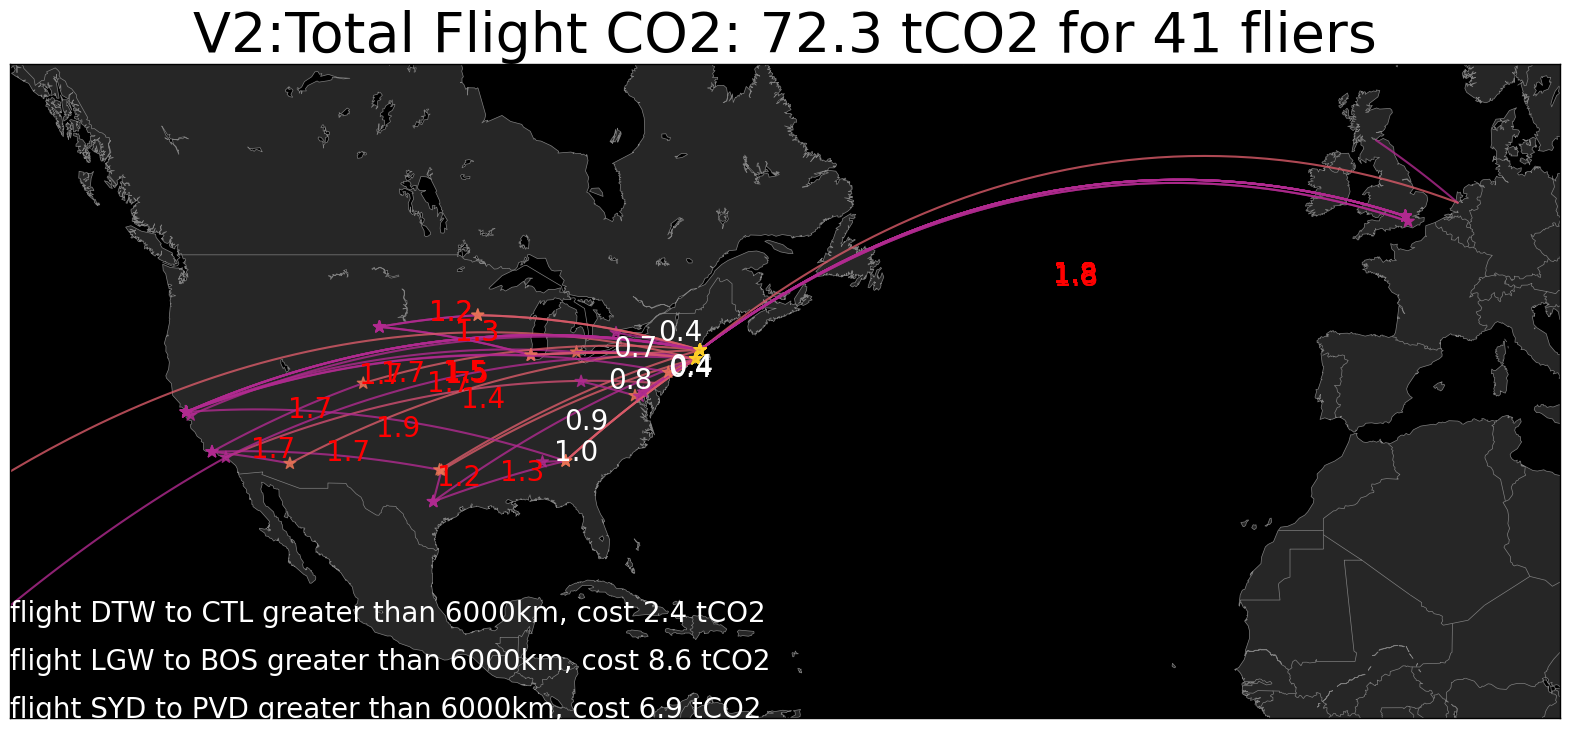

In [8]:
# Do the plotting

fig = plt.figure()

# basemap centered on New York
#m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,
#            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,
#            resolution='l')

m = Basemap(projection='merc',llcrnrlat=10,urcrnrlat=60,
            llcrnrlon=-140,urcrnrlon=15,lat_ts=20,
            resolution='l')


m.drawmapboundary(fill_color='black')
m.fillcontinents(color=[0.15,0.15,0.15],lake_color='black',zorder=1)
m.drawcoastlines(linewidth=0.5,color=[0.5,0.5,0.5])
m.drawcountries(linewidth=0.5,color=[0.5,0.5,0.5])
journey_co2s=[]
distances=[]
distances_broken=[]
nlong=0
for j,(long, lat) in enumerate(journeys):
    x,y = m(lat,long)
    temp=[]
    for i in range(len(x)-1):
        col = new_cmap(i/len(x))
        x1 = [lat[i],lat[i+1]]
        y1 = [long[i],long[i+1]]
        ln=m.drawgreatcircle(x1[0],y1[0],x1[1],y1[1],linewidth=1.5,color=col,alpha=0.8)
        temp.append(dist.distance((long[i],lat[i]),(long[i+1],lat[i+1])).km)
    co2=sum_journey(temp)
    journey_co2s.append(co2)
    distances.append(np.sum(temp))
    distances_broken.append(temp)
    if np.sum(temp)>6e3:
        plt.text(0.,500000.*nlong,
                 "flight %s to %s greater than 6000km, cost %.1f tCO2 "%(starts[j],ends[j],np.round(co2,decimals=1)),
                fontsize=20,color='white')
        nlong+=1 
        continue
    if co2>1:
        plt.text((x[0]+x[1])/2,(y[0]+y[1])/2,'%.1f'%np.round(co2,decimals=1),color='r',fontsize=20)
    if co2<1:
        plt.text((x[0]+x[1])/2,(y[0]+y[1])/2,'%.1f'%np.round(co2,decimals=1),color='white',fontsize=20)
    scatter=plt.scatter(x, y, marker='*', c = range(len(x)), cmap=new_cmap,alpha=0.8,s=80,zorder=2)
plt.title("V2:Total Flight CO2: %.1f tCO2 for %i fliers" %(np.sum(journey_co2s),len(journeys)),fontsize=40)
fig.savefig('travel_map.png')

['SYD', 'LAX', 'PHL', 'PVD']
[4128.445732179696, 256.74971464710103]
4385.195446826798
['DTW', 'BDL', 'CTL']
[4128.445732179696, 256.74971464710103]
4385.195446826798


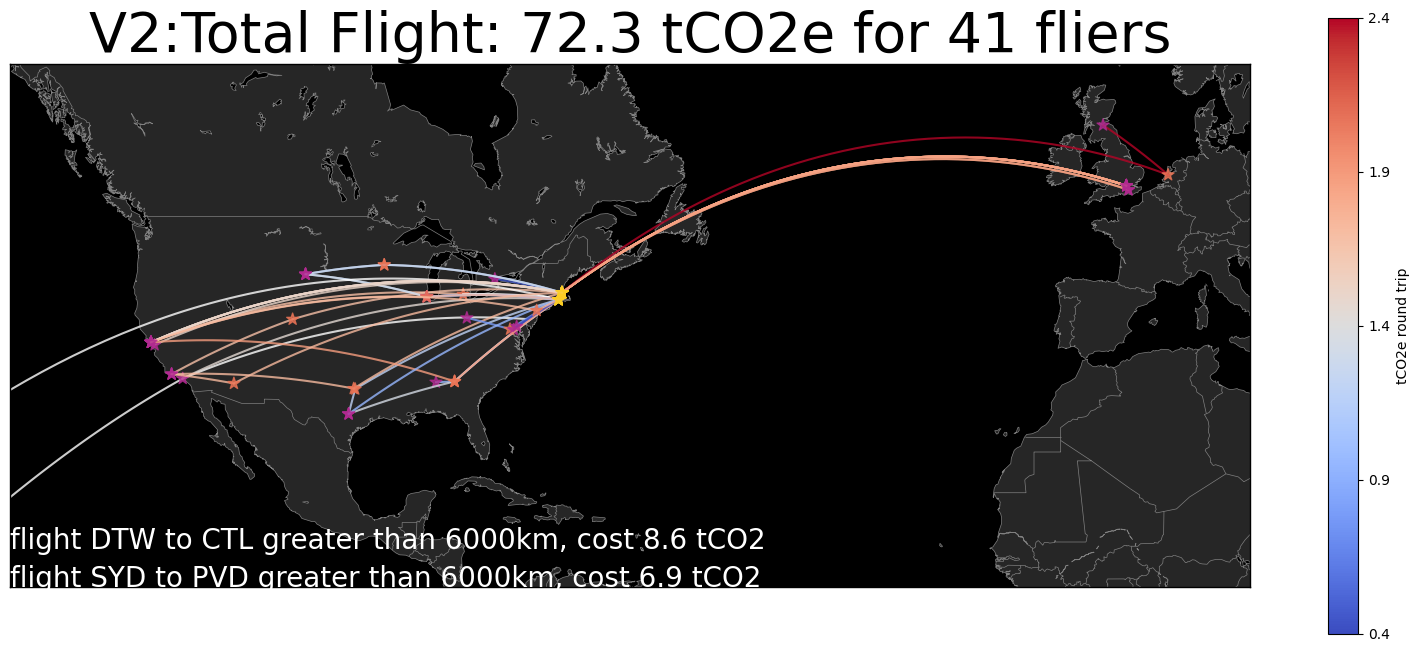

In [9]:
# Do the plotting
import matplotlib as mpl
fig = plt.figure()
carbon_map = matplotlib.colormaps['coolwarm']
# basemap centered on New York
#m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,
#            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,
#            resolution='l')

m = Basemap(projection='merc',llcrnrlat=10,urcrnrlat=60,
            llcrnrlon=-140,urcrnrlon=15,lat_ts=20,
            resolution='l')


m.drawmapboundary(fill_color='black')
m.fillcontinents(color=[0.15,0.15,0.15],lake_color='black',zorder=1)
m.drawcoastlines(linewidth=0.5,color=[0.5,0.5,0.5])
m.drawcountries(linewidth=0.5,color=[0.5,0.5,0.5])


#find the CO2s first
journey_co2s=[]
distances=[]
distances_broken=[]
for j,(long, lat) in enumerate(journeys):
    x,y = m(lat,long)
    temp=[]
    for i in range(len(x)-1):
        temp.append(dist.distance((long[i],lat[i]),(long[i+1],lat[i+1])).km)
    co2=sum_journey(temp)
    journey_co2s.append(co2)
    distances.append(np.sum(temp))
    distances_broken.append(temp)

ridiculous_co2=3.
cut_ridiculous=[co2 for co2 in journey_co2s if co2<ridiculous_co2]
scale_max_co2=max(cut_ridiculous)
scale_min_co2=min(cut_ridiculous)
nlong=0
for j,(long, lat) in enumerate(journeys):
    x,y = m(lat,long)
    co2=journey_co2s[j]
    
    for i in range(len(x)-1):
        if co2<ridiculous_co2:
            col = carbon_map((co2-scale_min_co2)/(scale_max_co2-scale_min_co2))#new_cmap(i/len(x))
        else:
            col = 'white'
        x1 = [lat[i],lat[i+1]]
        y1 = [long[i],long[i+1]]
        ln=m.drawgreatcircle(x1[0],y1[0],x1[1],y1[1],linewidth=1.5,color=col,alpha=0.8)
    
    if co2>ridiculous_co2:
        print(airports_journeys[j])
        print(temp)
        print(np.sum(temp))
        #starts and ends gives the wrong answers
        plt.text(0.,500000.*nlong,
                 "flight %s to %s greater than 6000km, cost %.1f tCO2 "%(airports_journeys[j][0],airports_journeys[j][-1],np.round(co2,decimals=1)),
                fontsize=20,color='white')
        nlong+=1 
        continue
    # if co2>1:
    #     plt.text((x[0]+x[1])/2,(y[0]+y[1])/2,'%.1f'%np.round(co2,decimals=1),color='r',fontsize=20)
    # if co2<1:
    #     plt.text((x[0]+x[1])/2,(y[0]+y[1])/2,'%.1f'%np.round(co2,decimals=1),color='white',fontsize=20)
    
    scatter=plt.scatter(x, y, marker='*', c = range(len(x)), cmap=new_cmap,alpha=0.8,s=80,zorder=2)
cmap = carbon_map
norm = mpl.colors.Normalize(vmin=scale_min_co2, vmax=scale_max_co2)

plt.colorbar(mpl.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
             label='tCO2e round trip',ticks=np.linspace(scale_min_co2,scale_max_co2,5,endpoint=True),
            format='%.1f')
plt.title("V2:Total Flight: %.1f tCO2e for %i fliers" %(np.sum(journey_co2s),len(journeys)),fontsize=40)
fig.savefig('travel_map.png')

['SYD', 'LAX', 'PHL', 'PVD']
[4128.445732179696, 256.74971464710103]
4385.195446826798
['DTW', 'BDL', 'CTL']
[4128.445732179696, 256.74971464710103]
4385.195446826798


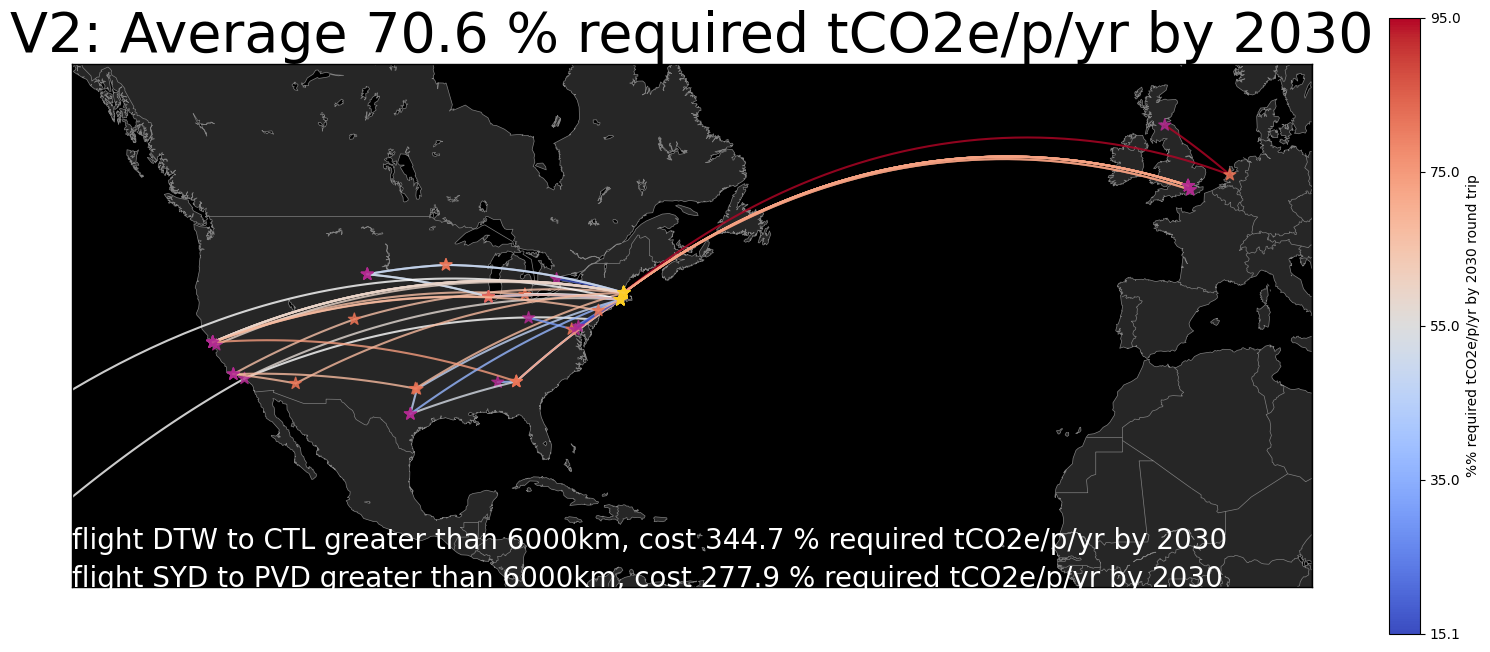

In [10]:
# Do the plotting
import matplotlib as mpl
fig = plt.figure()
carbon_map = matplotlib.colormaps['coolwarm']
# basemap centered on New York
#m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,
#            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,
#            resolution='l')

m = Basemap(projection='merc',llcrnrlat=10,urcrnrlat=60,
            llcrnrlon=-140,urcrnrlon=15,lat_ts=20,
            resolution='l')


m.drawmapboundary(fill_color='black')
m.fillcontinents(color=[0.15,0.15,0.15],lake_color='black',zorder=1)
m.drawcoastlines(linewidth=0.5,color=[0.5,0.5,0.5])
m.drawcountries(linewidth=0.5,color=[0.5,0.5,0.5])


#find the CO2s first
journey_co2s=[]
distances=[]
distances_broken=[]
for j,(long, lat) in enumerate(journeys):
    x,y = m(lat,long)
    temp=[]
    for i in range(len(x)-1):
        temp.append(dist.distance((long[i],lat[i]),(long[i+1],lat[i+1])).km)
    co2=100*sum_journey(temp)/2.5
    journey_co2s.append(co2)
    distances.append(np.sum(temp))
    distances_broken.append(temp)

ridiculous_co2=100*3./2.5
cut_ridiculous=[co2 for co2 in journey_co2s if co2<ridiculous_co2]
scale_max_co2=max(cut_ridiculous)
scale_min_co2=min(cut_ridiculous)
nlong=0
for j,(long, lat) in enumerate(journeys):
    x,y = m(lat,long)
    co2=journey_co2s[j]
    
    for i in range(len(x)-1):
        if co2<ridiculous_co2:
            col = carbon_map((co2-scale_min_co2)/(scale_max_co2-scale_min_co2))#new_cmap(i/len(x))
        else:
            col = 'white'
        x1 = [lat[i],lat[i+1]]
        y1 = [long[i],long[i+1]]
        ln=m.drawgreatcircle(x1[0],y1[0],x1[1],y1[1],linewidth=1.5,color=col,alpha=0.8)
    
    if co2>ridiculous_co2:
        print(airports_journeys[j])
        print(temp)
        print(np.sum(temp))
        #starts and ends gives the wrong answers
        plt.text(0.,500000.*nlong,
                 "flight %s to %s greater than 6000km, cost %.1f %% required tCO2e/p/yr by 2030 "%(airports_journeys[j][0],airports_journeys[j][-1],np.round(co2,decimals=1)),
                fontsize=20,color='white')
        nlong+=1 
        continue
    # if co2>1:
    #     plt.text((x[0]+x[1])/2,(y[0]+y[1])/2,'%.1f'%np.round(co2,decimals=1),color='r',fontsize=20)
    # if co2<1:
    #     plt.text((x[0]+x[1])/2,(y[0]+y[1])/2,'%.1f'%np.round(co2,decimals=1),color='white',fontsize=20)
    
    scatter=plt.scatter(x, y, marker='*', c = range(len(x)), cmap=new_cmap,alpha=0.8,s=80,zorder=2)
cmap = carbon_map
norm = mpl.colors.Normalize(vmin=scale_min_co2, vmax=scale_max_co2)

plt.colorbar(mpl.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
             label='%% required tCO2e/p/yr by 2030 round trip',ticks=np.linspace(scale_min_co2,scale_max_co2,5,endpoint=True),
            format='%.1f')
plt.title("V2: Average %.1f %% required tCO2e/p/yr by 2030" %(np.sum(journey_co2s)/len(journeys)),fontsize=40)
fig.savefig('travel_map.png')

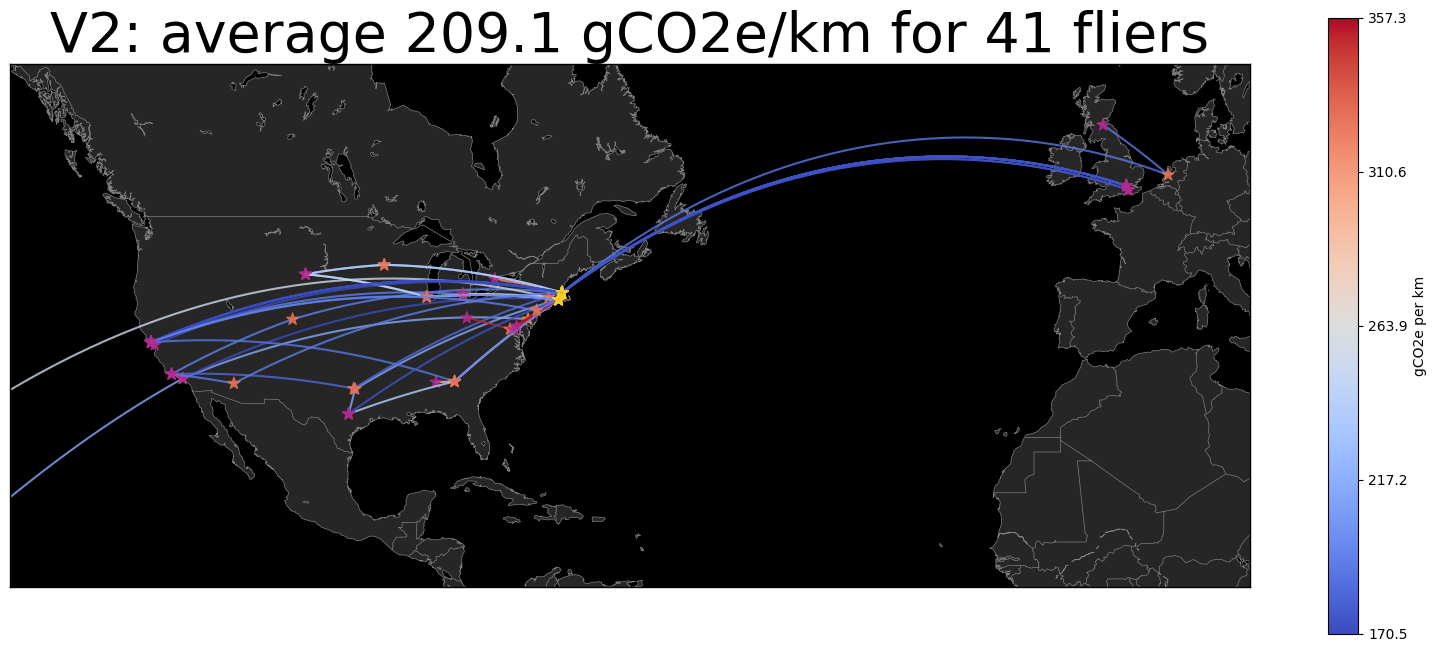

In [11]:
# Do the plotting
import matplotlib as mpl
fig = plt.figure()
carbon_map = matplotlib.colormaps['coolwarm']
# basemap centered on New York
#m = Basemap(projection='merc',llcrnrlat=-80,urcrnrlat=80,
#            llcrnrlon=-180,urcrnrlon=180,lat_ts=20,
#            resolution='l')

m = Basemap(projection='merc',llcrnrlat=10,urcrnrlat=60,
            llcrnrlon=-140,urcrnrlon=15,lat_ts=20,
            resolution='l')


m.drawmapboundary(fill_color='black')
m.fillcontinents(color=[0.15,0.15,0.15],lake_color='black',zorder=1)
m.drawcoastlines(linewidth=0.5,color=[0.5,0.5,0.5])
m.drawcountries(linewidth=0.5,color=[0.5,0.5,0.5])


#find the CO2s first
journey_co2s=[]
distances=[]
distances_broken=[]
for j,(long, lat) in enumerate(journeys):
    x,y = m(lat,long)
    temp=[]
    for i in range(len(x)-1):
        temp.append(dist.distance((long[i],lat[i]),(long[i+1],lat[i+1])).km)
    co2=1e6*sum_journey(temp)/(2*np.sum(temp))
    journey_co2s.append(co2)
    distances.append(np.sum(temp))
    distances_broken.append(temp)


# cut_ridiculous=[co2 for co2 in journey_co2s if co2<ridiculous_co2]
scale_max_co2=max(journey_co2s)
scale_min_co2=min(journey_co2s)
nlong=0
for j,(long, lat) in enumerate(journeys):
    x,y = m(lat,long)
    co2=journey_co2s[j]
    
    for i in range(len(x)-1):

        col = carbon_map((co2-scale_min_co2)/(scale_max_co2-scale_min_co2))#new_cmap(i/len(x))

        x1 = [lat[i],lat[i+1]]
        y1 = [long[i],long[i+1]]
        ln=m.drawgreatcircle(x1[0],y1[0],x1[1],y1[1],linewidth=1.5,color=col,alpha=0.8)

    
    scatter=plt.scatter(x, y, marker='*', c = range(len(x)), cmap=new_cmap,alpha=0.8,s=80,zorder=2)
cmap = carbon_map
norm = mpl.colors.Normalize(vmin=scale_min_co2, vmax=scale_max_co2)

plt.colorbar(mpl.cm.ScalarMappable(cmap=carbon_map,norm=norm),ax=plt.gca(),shrink=0.4,
             label='gCO2e per km',ticks=np.linspace(scale_min_co2,scale_max_co2,5,endpoint=True),
            format='%.1f')
plt.title("V2: average %.1f gCO2e/km for %i fliers" %(np.sum(journey_co2s)/len(journeys),len(journeys)),fontsize=40)
fig.savefig('travel_map.png')